In [1]:
# Imports
import simulation as sim
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from pprint import pprint
from tqdm import tqdm
from scipy.optimize import curve_fit

sim.main_exe = '../build/crystal'
import collapser as coll

In [2]:
# Phase 0: define variables and used parameters for run(). 
# Should be reloaded from file for the analysis.
nu = 0.63
beta = 0.33
crystals = {
    'lattice': {
        'params': {
            'f': '../cellfiles/lattice_cell.txt',
            't': 100001,
            'p': 0.11,
            'B': 0,
            'L': 10,
        },
        'LL': range(7, 20, 3),
        'bb': np.linspace(0.21, 0.24, 12),
        'bbs': np.linspace(0.21, 0.24, 20),
        'name': 'Standard lattice',
        'bc': 0.228,
    },
    'body': {
        'params': {
            'f': '../cellfiles/bodyCenteredCubic_cell.txt',
            't': 100001,
            'p': 0.11,
            'B': 0,
            'L': 10,
        },
        'LL': range(7, 20, 3),
        'bb': np.linspace(0.095, 0.115, 12),
        'bbs': np.linspace(0.100, 0.111, 20),
        'name': 'Body centered cubic',
        'bc': 0.108,
    },
    'face': {
        'params': {
            'f': '../cellfiles/faceCenteredCubic_cell.txt',
            't': 100001,
            'p': 0.11,
            'B': 0,
            'L': 10,
        },
        'LL': range(7, 20, 3),
        'bb': np.linspace(0.11, 0.14, 12),
        'bbs': np.linspace(0.11, 0.14, 20),
        'name': 'Face centered cubic',
        'bc': 0.125,
    },
    'diamond': {
        'params': {
            'f': '../cellfiles/diamond_cell.txt',
            't': 100001,
            'p': 0.11,
            'B': 0,
            'L': 10,
        },
        'LL': range(7, 20, 3),
        'bb': np.linspace(0.185, 0.235, 12),
        'bbs': np.linspace(0.185, 0.235, 20),
        'name': 'Diamond cubic',
        'bc': 0.205,
    },
}

Standard lattice
{'B': '0',
 'J': '1',
 'L': '8',
 'b': '0.256364',
 'cell.N': '1',
 'f': '../cellfiles/lattice_cell.txt',
 'model_size': '512',
 'p': '0.12',
 't': '50001'}


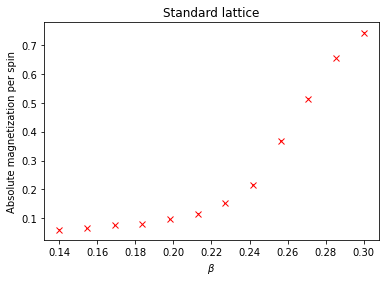

Body centered cubic
{'B': '0',
 'J': '1',
 'L': '6',
 'b': '0.123636',
 'cell.N': '2',
 'f': '../cellfiles/bodyCenteredCubic_cell.txt',
 'model_size': '432',
 'p': '0.12',
 't': '50001'}


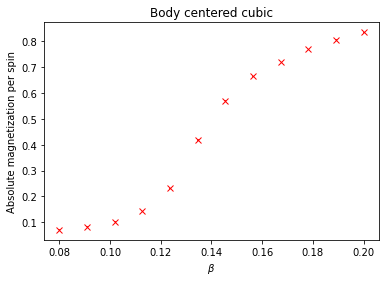

Face centered cubic
{'B': '0',
 'J': '1',
 'L': '5',
 'b': '0.189091',
 'cell.N': '4',
 'f': '../cellfiles/faceCenteredCubic_cell.txt',
 'model_size': '500',
 'p': '0.12',
 't': '50001'}


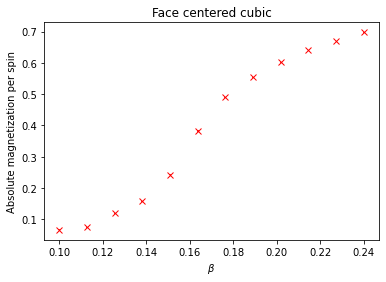

Diamond cubic
{'B': '0',
 'J': '1',
 'L': '4',
 'b': '0.34',
 'cell.N': '8',
 'f': '../cellfiles/diamond_cell.txt',
 'model_size': '512',
 'p': '0.12',
 't': '50001'}


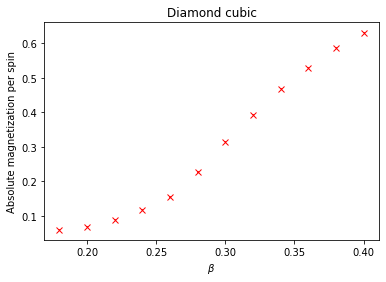

In [3]:
# Phase 1: get rough estimate of beta_c for all crystals
test_folder = '../sim_data/rough_005/'
Path(test_folder).mkdir(exist_ok=True)

for slug, crystal in crystals.items():
    print(crystal['name'])
    s = sim.Span(test_folder+slug)
    if not s.runned:
        s.run('b', crystal['bb'], load=True, log=True, **crystal['params'])
    pprint(s.simulations[0].kwargs)
    bb = []; mm = []; err = []
    DISCARD = 2000
    for simul in s.simulations:
        bb.append(float(simul.kwargs['b']))
        absm = np.abs(simul.data['m'])[DISCARD:]
        mm.append(np.mean(absm))
        err.append(sim.bootstrap(absm))
    plt.errorbar(bb, mm, err, ecolor="red", fmt="rx")
    plt.title(crystal['name'])
    plt.ylabel('Absolute magnetization per spin')
    plt.xlabel('$\\beta$')
    plt.savefig('MamaImages/'+
                'single'+'_magnetization_'+slug+'.png')
    plt.show()

Processing lattice
Loading spans


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


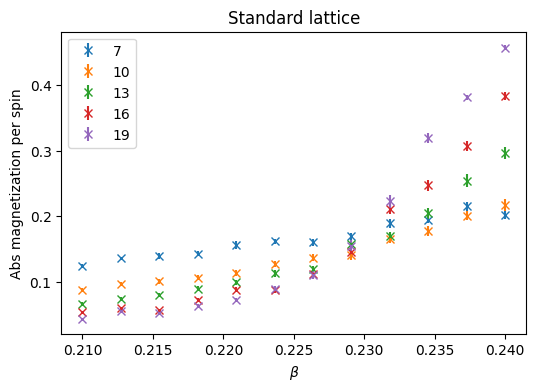

Processing body
Loading spans


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


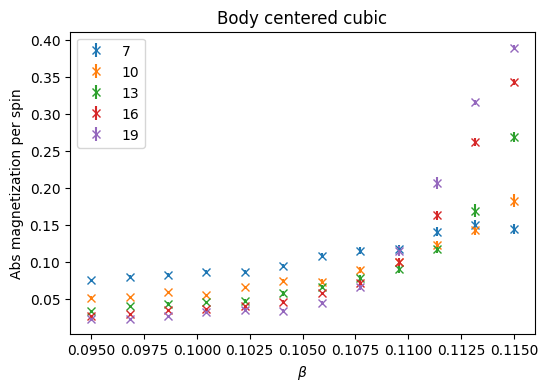

Processing face
Loading spans


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


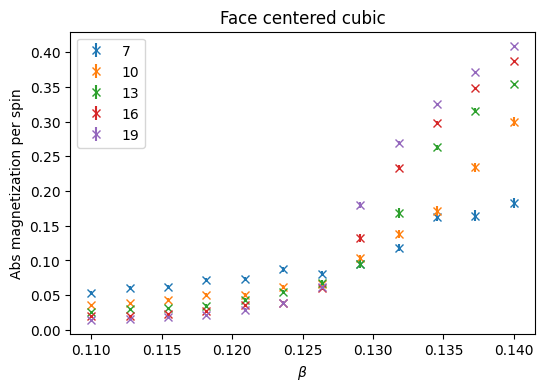

Processing diamond
Loading spans


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


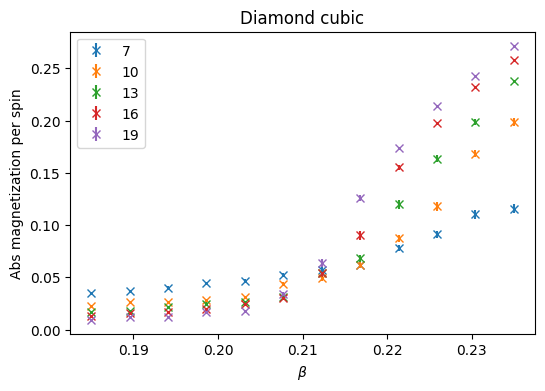

In [5]:
# Phase 2: get data for different L
LL_path = Path("../sim_data/groupLL004")
LL_path.mkdir(exist_ok=True)
BLOCKSIZE=100

for slug, crystal in crystals.items():
    print("Processing", slug)
    crystal['my_LL'] = coll.LL(LL_path/slug, load=True, DISCARD=2000, blocksize=BLOCKSIZE, resample=100)
    my_LL = crystal['my_LL']
    if not my_LL.runned:
        my_LL.run(crystal['LL'], crystal['bb'], **crystal['params'], load=True, blocksize=BLOCKSIZE, DISCARD=2000)
    plt.figure(dpi=100)
    my_LL.plot(b='b', m='m', m_err='m_err')
    plt.legend()
    plt.ylabel('Abs magnetization per spin')
    plt.xlabel('$\\beta$')
    plt.title(crystal['name'])
    plt.savefig('MamaImages/'+
                'raw'+'_magnetization_'+slug+'.png')
    plt.show()

In [5]:
# Phase 3: hand plot, with guesses of nu, beta, beta_c, 
# yy = \tilda m_0(L^{1/\nu}*t) = m*L^{\beta/\nu} vs xx = L^{1/\nu}*t
# --SKIPPED

In [6]:
# Phase 4: Implement the multiple histogram method 
# to handle continuous values of beta

In [7]:
# Phase 4A: compute Z for simulation temps
for slug, crystal in crystals.items():
    print("Computing Z for", slug)
    crystal['my_LL'].compute_Z(DISCARD=2000, prec=0.99, log=True)
    #print(type(list(crystal['my_LL'].data.values())[0]['Z'][0])) - Holy crap! I had to change to np.float128!

Computing Z for lattice
Examining L=7


  0%|          | 4/10000 [00:02<1:24:17,  1.98it/s]

Zlast [3.85431138e-03 7.21015358e-03 1.36785555e-02 2.63174656e-02
 5.13917545e-02 1.01917998e-01 2.05457175e-01 4.21121279e-01
 8.78582556e-01 1.86747403e+00 4.04952600e+00 8.96389567e+00]
Z [0.0038762561327829964153, 0.007244687414336757082, 0.01373121042019454442, 0.026393054586361063708, 0.051487133958348491308, 0.10199943438654968278, 0.20539544348282528476, 0.42051349917164570352, 0.87627096564059080944, 1.860256326405275504, 4.0286864883799584297, 8.905864049008469315]
Examining L=10



  0%|          | 8/10000 [00:03<1:15:56,  2.19it/s]

Zlast [1.23512497e-09 8.75822684e-09 6.51077745e-08 5.07872323e-07
 4.17124190e-06 3.61820078e-05 3.32903345e-04 3.25696620e-03
 3.40755667e-02 3.83520526e-01 4.68256051e+00 6.24976981e+01]
Z [1.2361315544395605553e-09, 8.764398742794579162e-09, 6.514570621665016428e-08, 5.081000126662574771e-07, 4.1725003939121715225e-06, 3.6187183328477427285e-05, 0.00033289435363048432532, 0.0032562917115565148515, 0.034062088223209641968, 0.38329418321092367005, 4.6788687396095795393, 62.436006178759117853]
Examining L=13



  0%|          | 16/10000 [00:06<1:11:34,  2.32it/s]

Zlast [2.03383484e-22 1.76575238e-20 1.72092775e-18 1.89125934e-16
 2.36976132e-14 3.42392501e-12 5.79438428e-10 1.16438603e-07
 2.84954274e-05 8.77496770e-03 3.56311370e+00 2.00346028e+03]
Z [2.027169301897388769e-22, 1.7605033471290478012e-20, 1.7164662086255345591e-18, 1.8872428128980033971e-16, 2.3660758633177080613e-14, 3.420908813750395947e-12, 5.793795012921794055e-10, 1.1652855641245288006e-07, 2.8544536599022584836e-05, 0.008798823083853510479, 3.5763049556603849935, 2012.6509550655705841]
Examining L=16



  0%|          | 31/10000 [00:12<1:09:22,  2.40it/s]

Zlast [2.34837571e-43 1.18109714e-39 7.46041285e-36 5.98507149e-32
 6.25108709e-28 8.73549901e-24 1.70314004e-19 4.86917040e-15
 2.22055152e-10 1.79369693e-05 2.92701021e+00 1.06761231e+06]
Z [2.3330094934921383727e-43, 1.1738690672105545575e-39, 7.419129253630423946e-36, 5.9566901357843485564e-32, 6.2279335104425784984e-28, 8.7147070203718559966e-24, 1.7019066595264353415e-19, 4.875496187470336206e-15, 2.228656195819638386e-10, 1.8047338617277591438e-05, 2.951809662116445492, 1078472.4113980335158]
Examining L=19



  1%|          | 57/10000 [00:23<1:08:11,  2.43it/s]

Zlast [1.33588732e-74 2.76726360e-68 8.55286877e-62 3.99867119e-55
 2.93753627e-48 3.56733897e-41 7.86581005e-34 3.61384677e-26
 4.49433189e-18 2.12626658e-09 4.53125630e+00 4.22190166e+10]
Z [1.3247220009030554261e-74, 2.7452331542913512052e-68, 8.489863218017113614e-62, 3.972599624029639049e-55, 2.9217784186680747972e-48, 3.5537292109375630373e-41, 7.852157087020774722e-34, 3.617737124228998948e-26, 4.5160636036344548536e-18, 2.1454012548178008258e-09, 4.586425535620012933, 42811541453.98274795]
Computing Z for body
Examining L=7



  0%|          | 6/10000 [00:02<1:18:33,  2.12it/s]

Zlast [2.27617338e-04 5.35032739e-04 1.29812458e-03 3.25675414e-03
 8.45941955e-03 2.28036366e-02 6.39455581e-02 1.87057245e-01
 5.72718967e-01 1.84389790e+00 6.26506523e+00 2.26159820e+01]
Z [0.00022824742604532885614, 0.00053630325611430028303, 0.0013006553413099832814, 0.0032616114372224537665, 0.008467875824531047511, 0.022814430927053457762, 0.06393996935681684293, 0.18692965805295295153, 0.57196907715236936697, 1.8402703274558312315, 6.248450829811135501, 22.540020421960446495]
Examining L=10



  0%|          | 14/10000 [00:06<1:12:04,  2.31it/s]

Zlast [4.64569262e-14 7.17289567e-13 1.22891165e-11 2.35498787e-10
 5.08200168e-09 1.24819724e-07 3.52863704e-06 1.16353703e-04
 4.55092402e-03 2.16640095e-01 1.29638119e+01 1.03662055e+03]
Z [4.629754452751186173e-14, 7.1507221668181710295e-13, 1.2256272303156519183e-11, 2.3498947510222755468e-10, 5.074108640888087612e-09, 1.2471467513674440987e-07, 3.528513164582280289e-06, 0.00011645255656872201387, 0.004559064766541471685, 0.2172374156635571761, 13.01213428143821106, 1041.4554527071332596]
Examining L=13



  0%|          | 33/10000 [00:13<1:09:08,  2.40it/s]

Zlast [4.86329153e-33 2.68974482e-30 1.91974118e-27 1.80126154e-24
 2.25787260e-21 3.88595291e-18 9.50368961e-15 3.46274628e-11
 2.00005659e-07 2.00803199e-03 4.08378736e+01 2.30817855e+06]
Z [4.8333856218068983698e-33, 2.6743297582567342646e-30, 1.9098576466043863793e-27, 1.7934020225766377765e-24, 2.2503203962763098377e-21, 3.8779156062635013675e-18, 9.498755097058120188e-15, 3.467215200982324031e-11, 2.0066597562141348221e-07, 0.002018956075414133233, 41.150595053857938876, 2330416.7635172609137]
Examining L=16



  1%|          | 68/10000 [00:27<1:07:52,  2.44it/s]

Zlast [2.32375554e-64 4.36347399e-59 1.35053451e-53 7.17252727e-48
 6.75876814e-42 1.20062158e-35 4.39096622e-29 3.70346676e-22
 8.60093773e-15 8.19602882e-07 6.14992732e+02 6.36746106e+12]
Z [2.3038131117657979577e-64, 4.3277680488012803654e-59, 1.3403319780121658159e-53, 7.124925348890239505e-48, 6.7223578190301872567e-42, 1.196127450509501458e-35, 4.383697696054410464e-29, 3.7067203703613330343e-22, 8.635760124627828918e-15, 8.263384145310046016e-07, 622.87811240738506857, 6467904667500.454489]
Examining L=19



  1%|▏         | 127/10000 [00:51<1:07:04,  2.45it/s]

Zlast [4.38347020e-111 4.65782449e-102 1.17082920e-092 7.48744437e-083
 1.29694139e-072 6.77985250e-062 1.27691778e-050 1.10305745e-038
 6.29876768e-026 7.30109071e-012 8.73138186e+004 1.21167181e+023]
Z [4.3436789808628251753e-111, 4.6170472013201244993e-102, 1.1612376341774355586e-92, 7.432570328901153298e-83, 1.2889932495220715829e-72, 6.7491402655555987958e-62, 1.2738401465186447606e-50, 1.10330625167760809814e-38, 6.322691139870113908e-26, 7.370051271812980596e-12, 88625.039571363912025, 1.2334035219136037491e+23]
Computing Z for face
Examining L=7



  0%|          | 12/10000 [00:05<1:12:56,  2.28it/s]

Zlast [4.80371126e-10 3.37215322e-09 2.57137976e-08 2.13662226e-07
 1.94659465e-06 1.95767802e-05 2.19422591e-04 2.76709149e-03
 3.98774192e-02 6.69437895e-01 1.34363602e+01 3.32194828e+02]
Z [4.7957923302976449816e-10, 3.3671927873371513351e-09, 2.5681388993865845712e-08, 2.1344577728315208427e-07, 1.9451820368307687668e-06, 1.9569029832669242135e-05, 0.00021941755216830060058, 0.0027681715789406932282, 0.039910805264446418224, 0.67031175312330745043, 13.460233789901361336, 332.9348714066109979]
Examining L=10



  0%|          | 36/10000 [00:14<1:09:00,  2.41it/s]

Zlast [4.37837948e-32 1.86465693e-29 1.03553387e-26 7.61298585e-24
 7.60691925e-21 1.06748860e-17 2.21182487e-14 7.19944544e-11
 4.06260384e-07 4.57397665e-03 1.25898097e+02 1.01784207e+07]
Z [4.3459400498590350827e-32, 1.851668560845966808e-29, 1.02896978890723224074e-26, 7.571263310619843906e-24, 7.573911960856532118e-21, 1.064434455971406351e-17, 2.2096289826721152915e-14, 7.208791680337578313e-11, 4.0788687238053865138e-07, 0.004606096129046339441, 127.15274841387285406, 10301551.345091361508]
Examining L=13



  1%|          | 95/10000 [00:38<1:07:24,  2.45it/s]

Zlast [2.23544613e-74 2.11187530e-68 3.71193346e-62 1.27588419e-55
 9.26502572e-49 1.52826672e-41 6.45225674e-34 8.90221293e-26
 7.04954108e-17 6.93929755e-07 1.01693441e+05 1.48650353e+17]
Z [2.2154364500555237709e-74, 2.0936820485922885977e-68, 3.6820306879362179164e-62, 1.266705849239221499e-55, 9.209536842337797713e-49, 1.52151814277973304e-41, 6.4372088205048951757e-34, 8.9083044877488073543e-26, 7.085940285539908379e-17, 7.0112587145521709143e-07, 103098.71202295544579, 1.5095682432708601988e+17]
Examining L=16



  2%|▏         | 201/10000 [01:21<1:06:22,  2.46it/s]

Zlast [3.85310955e-143 8.88295102e-132 6.70283929e-120 1.74136275e-107
 1.84700800e-094 1.03508819e-080 4.03464471e-066 2.32885137e-050
 1.51375340e-032 1.71273797e-012 3.23872864e+010 5.57603206e+034]
Z [3.8166143982217077821e-143, 8.801225508050461576e-132, 6.644438986111007824e-120, 1.727527675755072978e-107, 1.8344922662043054786e-94, 1.0297439949267222589e-80, 4.0226370530027969791e-66, 2.3307802073748541964e-50, 1.5240574706353471397e-32, 1.7323278972343716902e-12, 32867407532.524829514, 5.667187101780864901e+34]
Examining L=19



  4%|▎         | 371/10000 [02:30<1:05:01,  2.47it/s]

Zlast [4.54305865e-246 9.24375103e-227 1.55046807e-206 2.38780473e-185
 4.34495125e-163 1.28994234e-139 1.44117600e-114 4.15063383e-087
 1.65993792e-055 4.23023636e-020 5.26257388e+019 1.45627543e+062]
Z [4.4989902814720575396e-246, 9.156195680037592292e-227, 1.5364780749566255175e-206, 2.3679706730475034389e-185, 4.3133523394279676848e-163, 1.2824384928013643113e-139, 1.4360978751080390069e-114, 4.1560458031426089666e-87, 1.6727252432774157037e-55, 4.2818084378466107436e-20, 5.342606703259344051e+19, 1.4806071854897675622e+62]
Computing Z for diamond
Examining L=7



  0%|          | 18/10000 [00:07<1:10:57,  2.34it/s]

Zlast [4.60418850e-26 8.16376095e-24 1.69159375e-21 4.10142096e-19
 1.17216571e-16 3.96539278e-14 1.60654030e-11 7.86830132e-09
 4.74233957e-06 3.57086171e-03 3.43831885e+00 4.31778827e+03]
Z [4.589431362549706572e-26, 8.1403978352998159314e-24, 1.6874712541633370025e-21, 4.093528698849974628e-19, 1.1706165403754273836e-16, 3.9628764508063153377e-14, 1.6067386827213263343e-11, 7.875602303603894529e-09, 4.7506072627954522065e-06, 0.0035798816148364743948, 3.4494345143716201938, 4334.329211662341877]
Examining L=10



  1%|          | 53/10000 [00:21<1:08:15,  2.43it/s]

Zlast [1.96032041e-80 1.34733289e-73 1.48486384e-66 2.64192235e-59
 7.85920384e-52 4.04403644e-44 3.84020463e-36 7.19876086e-28
 2.95623672e-19 3.09176563e-10 1.05027158e+00 1.31529109e+10]
Z [1.9444507883663795778e-80, 1.3371073445250462119e-73, 1.474709912700126706e-66, 2.6266432625206933816e-59, 7.824774112034295589e-52, 4.033460079902806099e-44, 3.8383299967940620784e-36, 7.21278949039241544e-28, 2.9698773365822259189e-19, 3.114861997803136582e-10, 1.0608363815546148466, 13306779499.919219206]
Examining L=13



  1%|▏         | 129/10000 [00:52<1:07:00,  2.46it/s]

Zlast [2.74009680e-182 6.26299847e-167 4.27326195e-151 9.02963874e-135
 6.51128732e-118 1.71096300e-100 1.95145785e-082 1.21928853e-063
 6.51348143e-044 5.65582649e-023 9.81244903e-001 3.48860084e+023]
Z [2.7147650313954798923e-182, 6.207750167851062294e-167, 4.2387183610145930065e-151, 8.9668127613732060695e-135, 6.475878595363627041e-118, 1.7049363051176959816e-100, 1.9493093468358571442e-82, 1.2215348321932078529e-63, 6.549765054569322503e-44, 5.7094150545397473396e-23, 0.9933507952049916885, 3.5372459026383304527e+23]
Examining L=16



  3%|▎         | 266/10000 [01:47<1:05:49,  2.46it/s]

Zlast [4.31834404e-347 4.97642531e-318 4.62903781e-288 3.80209144e-257
 3.37688933e-225 3.82448845e-192 8.22098074e-158 7.45315020e-122
 1.27232163e-083 8.58499958e-043 1.78705979e+001 9.57218192e+046]
Z [4.276762801991720898e-347, 4.9302817046232035152e-318, 4.589313059452143877e-288, 3.773527493672021897e-257, 3.356535502772708449e-225, 3.8086391761181683468e-192, 8.207649950853881228e-158, 7.467517070788719277e-122, 1.2807637911865548727e-83, 8.6744324938394447495e-43, 18.107186350515353789, 9.711645455921673253e+46]
Examining L=19



  5%|▍         | 480/10000 [03:14<1:04:13,  2.47it/s]

Zlast [1.23377554e-589 1.61419912e-540 7.36326252e-490 1.39993519e-437
 1.54056687e-383 1.50037141e-327 3.24131778e-269 1.59182160e-207
 1.13114660e-141 1.44407656e-071 2.99975518e+003 5.96670196e+081]
Z [1.2216781931094450085e-589, 1.5988565915309437759e-540, 7.297783636414358401e-490, 1.3888265843751333597e-437, 1.5303811537199529988e-383, 1.493199922714956113e-327, 3.2343324230992970418e-269, 1.5957261827890774962e-207, 1.1391164840359997133e-141, 1.4602036768971838603e-71, 3041.1837340315946827, 6.0574377177785879618e+81]


In [8]:
# Phase 4B: use that Zs to draw the mm line
for slug, crystal in crystals.items():
    my_LL = crystal['my_LL']
    # Write down the xx
    for L, data in sorted(my_LL.data.items(), key=lambda x: x[0]):
        data['bb'] = np.linspace(
            np.min(data['b']),
            np.max(data['b']),
            20
        )
    # Compute the ZZ
    my_LL.compute_obs('ZZ', 'bb')
    # Compute mm
    def get_m(simul):
        return np.abs(simul.data['m'])
    my_LL.compute_obs('mm', 'bb', ZZ_name='ZZ', 
                      obs=get_m, DISCARD=2000)

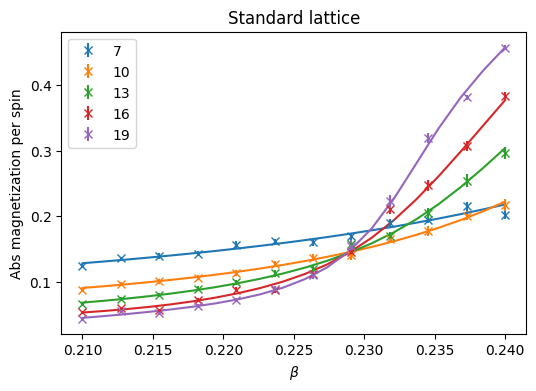

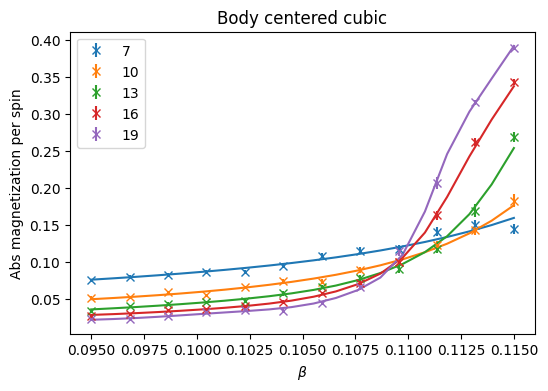

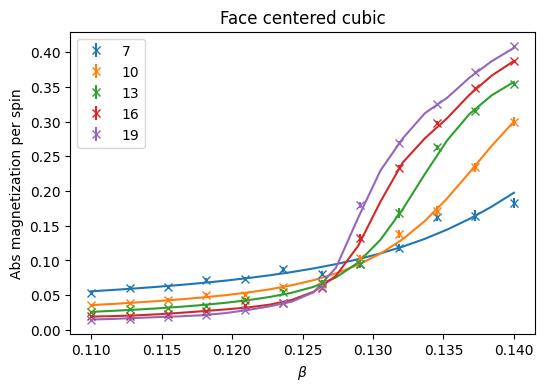

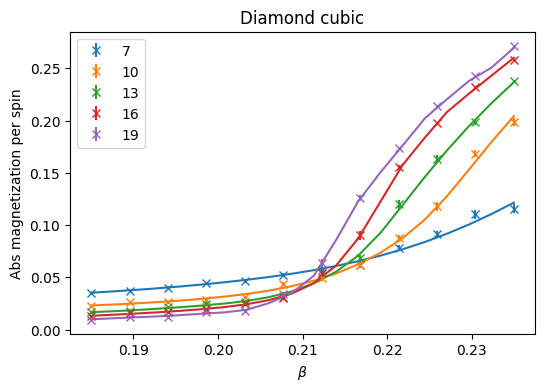

In [9]:
# Phase 4C: plot those damn lines!
for slug, crystal in crystals.items():
    my_LL = crystal['my_LL']
    plt.figure(dpi=100)
    my_LL.plot(b='b',m='m',m_err='m_err', bb='bb', mm='mm')
    plt.legend()
    plt.ylabel('Abs magnetization per spin')
    plt.xlabel('$\\beta$')
    plt.title(crystal['name'])
    plt.savefig('MamaImages/'+
                'line'+'_magnetization_'+slug+'.png')
    plt.show()

Beginning lattice
0.63 0.33 0.228


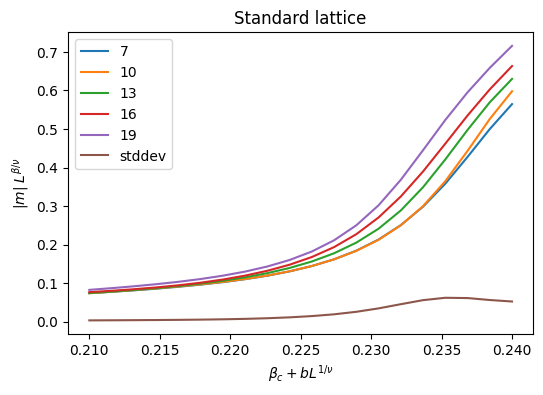

0.63 0.33 0.228
0.63 0.33 0.228
0.63 0.33 0.228
0.6300000093877316 0.33 0.228
0.63 0.3300000049173832 0.228
0.63 0.33 0.22800000339746476
0.6396528809441964 0.343710292662569 0.22315938109228853
0.639652890475767 0.343710292662569 0.22315938109228853
0.6396528809441964 0.34371029778425144 0.22315938109228853
0.6396528809441964 0.343710292662569 0.22315938441762243
0.6119648935564834 0.28978219085828627 0.22565193817318296
0.6119648935564834 0.28978219085828627 0.22565193817318296
0.6104637772455941 0.30225138457807355 0.22524369779350553
0.6104637863422132 0.30225138457807355 0.22524369779350553
0.6104637772455941 0.30225138908197013 0.22524369779350553
0.6104637772455941 0.30225138457807355 0.22524370114989817
0.6424619330958609 0.2761103198735295 0.22412650976223275
0.630388933623893 0.28244868175266763 0.2242047369053612
0.6303889430174201 0.28244868175266763 0.2242047369053612
0.630388933623893 0.282448685961481 0.2242047369053612
0.630388933623893 0.28244868175266763 0.22420474024

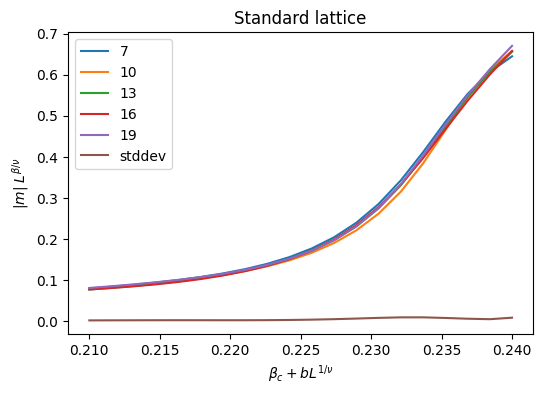

Beginning body
0.63 0.33 0.108


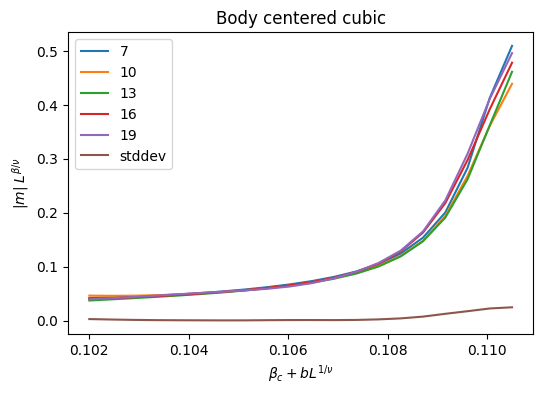

0.63 0.33 0.108
0.63 0.33 0.108
0.63 0.33 0.108
0.6300000093877316 0.33 0.108
0.63 0.3300000049173832 0.108
0.63 0.33 0.10800000160932541
0.6124286368688102 0.258451854655653 0.1075166224587686
0.6244824769788425 0.3224237194379881 0.10793977794858563
0.6244824862843565 0.3224237194379881 0.10793977794858563
0.6244824769788425 0.3224237242424759 0.10793977794858563
0.6244824769788425 0.3224237194379881 0.10793977955701366
0.6361534301602539 0.32322520691321865 0.10791420608551558
0.6297577640564516 0.322982162698111 0.10793194665104942
0.6297577734405735 0.322982162698111 0.10793194665104942
0.6297577640564516 0.32298216751092024 0.10793194665104942
0.6297577640564516 0.322982162698111 0.10793194825936075
0.6286125299484204 0.3198340349568744 0.10790005249592179
0.6291273562402533 0.32148331925903434 0.10791691383203503
0.6291273656149814 0.32148331925903434 0.10791691383203503
0.6291273562402533 0.3214833240495091 0.10791691383203503
0.6291273562402533 0.32148331925903434 0.1079169154

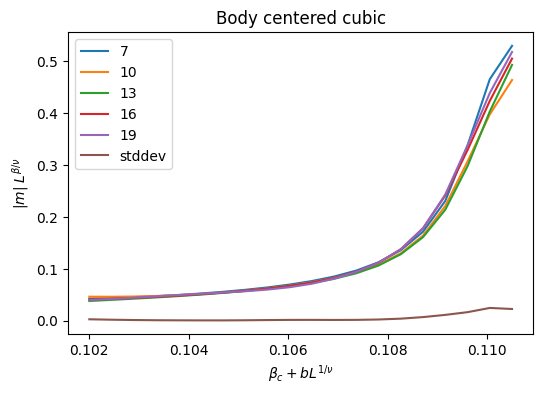

Beginning face
0.63 0.33 0.125


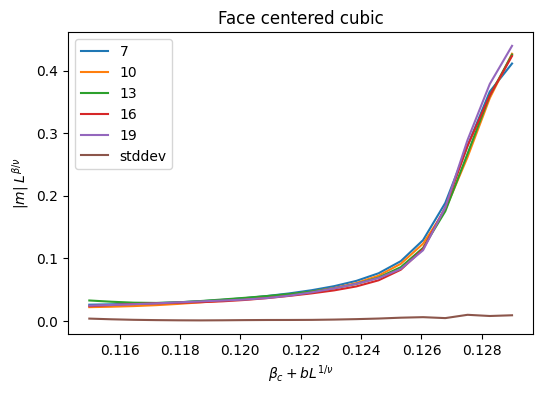

0.63 0.33 0.125
0.63 0.33 0.125
0.63 0.33 0.125
0.6300000093877316 0.33 0.125
0.63 0.3300000049173832 0.125
0.63 0.33 0.12500000186264515
0.5172067593909464 0.330324417508124 0.12533148868664698
0.6085345685388099 0.3240010560403313 0.12498906308972739
0.6085345776066816 0.3240010560403313 0.12498906308972739
0.6085345685388099 0.32400106086832325 0.12498906308972739
0.6085345685388099 0.3240010560403313 0.12498906495220957
0.6182896853405911 0.32933769837711674 0.12513420394689478
0.6134989845688663 0.3267009430024955 0.12505192368953014
0.6134989937107136 0.3267009430024955 0.12505192368953014
0.6134989845688663 0.32670094787071896 0.12505192368953014
0.6134989845688663 0.3267009430024955 0.125051925552949
0.6044379687806095 0.32541278577052274 0.1250903083873241
0.6044379777874371 0.32541278577052274 0.1250903083873241
0.6044379687806095 0.32541279061955114 0.1250903083873241
0.6044379687806095 0.32541278577052274 0.12509031025131495
0.6068374309577648 0.3276700861219664 0.125157313

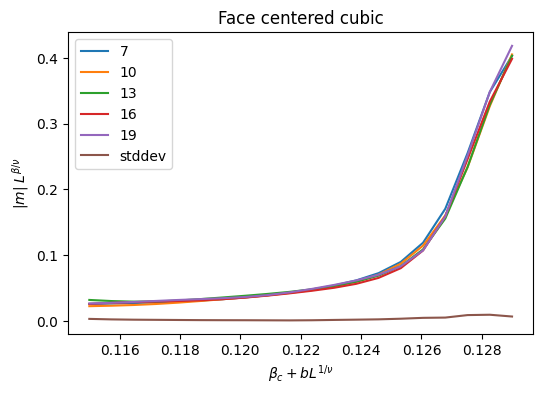

Beginning diamond
0.63 0.33 0.205


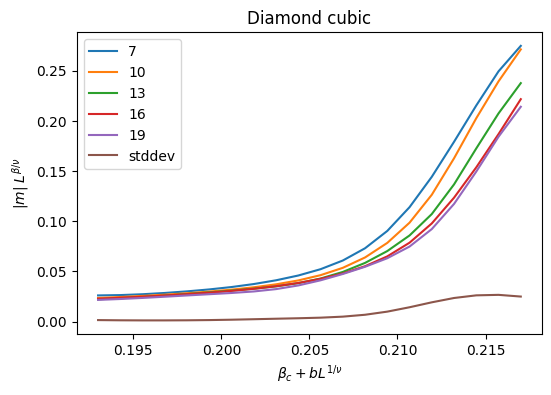

0.63 0.33 0.205
0.63 0.33 0.205
0.63 0.33 0.205
0.6300000093877316 0.33 0.205
0.63 0.3300000049173832 0.205
0.63 0.33 0.20500000305473803
0.6695020215214929 0.4356265552557005 0.20636606557943962
0.6695020314978504 0.4356265552557005 0.20636606557943962
0.6695020215214929 0.435626561747042 0.20636606557943962
0.6695020215214929 0.4356265552557005 0.20636606865453364
0.5423756776782303 0.33862056331180684 0.20860909774205996
0.6473807033904512 0.3959905318965593 0.2063662210133072
0.6676309762561823 0.42979384057222186 0.20634175307324817
0.6676309862046591 0.42979384057222186 0.20634175307324817
0.6676309762561823 0.4297938469766492 0.20634175307324817
0.6676309762561823 0.42979384057222186 0.2063417561479799
0.6685509939327768 0.4303385037236738 0.2064164167618582
0.6685510038949629 0.4303385037236738 0.2064164167618582
0.6685509939327768 0.4303385101362172 0.2064164167618582
0.6685509939327768 0.4303385037236738 0.2064164198377025
0.6676152776024986 0.4273622512719625 0.2064067489329

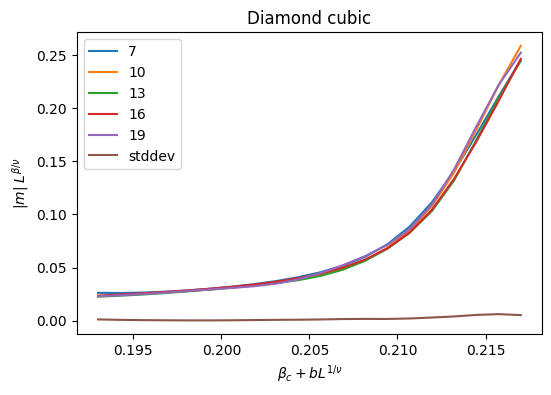

In [24]:
# Phase 5: use an implicit fit to find 
# \nu, \beta, \beta_c from the curve functions

crystals['lattice']['bbs'] = np.linspace(0.21, 0.24, 20)
crystals['lattice']['bc'] = 0.228
crystals['body']['bbs'] = np.linspace(0.102, 0.1105, 20)
crystals['body']['bc'] = 0.108
crystals['face']['bbs'] = np.linspace(0.115, 0.129, 20)
crystals['face']['bc'] = 0.125
crystals['diamond']['bbs'] = np.linspace(0.193, 0.217, 20)
crystals['diamond']['bc'] = 0.205

for slug, crystal in crystals.items():
    if 'popt' in crystal.keys(): # We don't refit what's good
        continue
    print("Beginning", slug)
    my_LL = crystal['my_LL']
    bb = crystal['bbs'] # Something shorter for the fit
    p0 = (0.63, 0.33, crystal['bc'])
    
    plt.figure(dpi=100)
    plt.plot(bb, my_LL.curve_stddev_m(bb, *p0, plot=True), 
             label='stddev')
    plt.legend()
    plt.ylabel('$|m| \\; L^{\\beta/\\nu}$')
    plt.xlabel('$\\beta_c + b L^{1/\\nu}$')
    plt.title(crystal['name'])
    plt.savefig('MamaImages/'+
                'prefit'+'_magnetization_'+slug+'.png')
    plt.show()
    
    popt, pcov = curve_fit(my_LL.curve_stddev_m, bb, 
                           np.zeros(len(bb)), p0=p0)
    with open("MamaImages/fit_result_"+slug+".txt", "w") as fp:
        fp.writeln(str(popt))
        fp.writeln(str(np.sqrt(np.diag(pcov))))
        fp.writeln(str(pcov))
    print("popt", popt)
    print("stddev", np.sqrt(np.diag(pcov)))
    print("pcov", pcov)
    crystal['popt'] = popt
    crystal['pcov'] = pcov
    
    plt.figure(dpi=100)
    plt.plot(bb, my_LL.curve_stddev_m(bb, *popt, plot=True), 
             label='stddev')
    plt.legend()
    plt.ylabel('$|m|\\; L^{\\beta/\\nu}$')
    plt.xlabel('$\\beta_c + b L^{1/\\nu}$')
    plt.title(crystal['name'])
    plt.savefig('MamaImages/'+
                'fit'+'_magnetization_'+slug+'.png')
    plt.show()

In [21]:
# When something is rotten
del crystals['diamond']['popt'] # Replace cname with the slug to refit